In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import h5py
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import sys
sys.path.append('../')
import KMeans
%matplotlib inline
DIR_DATASET = "../data_set/"

In [2]:
filename = "N-CMAPSS_DS05.h5"

In [3]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=17, option='Time', name=None):
    """
    """
    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, format='png', dpi=300)   
    plt.show()
    plt.close()

In [4]:
# Load data
with h5py.File(DIR_DATASET + filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))

W shape: (6912652, 4)
X_s shape: (6912652, 14)
X_v shape: (6912652, 14)
T shape: (6912652, 10)
A shape: (6912652, 4)


In [5]:
df_A = DataFrame(data=A, columns=A_var)
df_W = DataFrame(data=W, columns=W_var)
df_W['unit'] = df_A['unit'].values


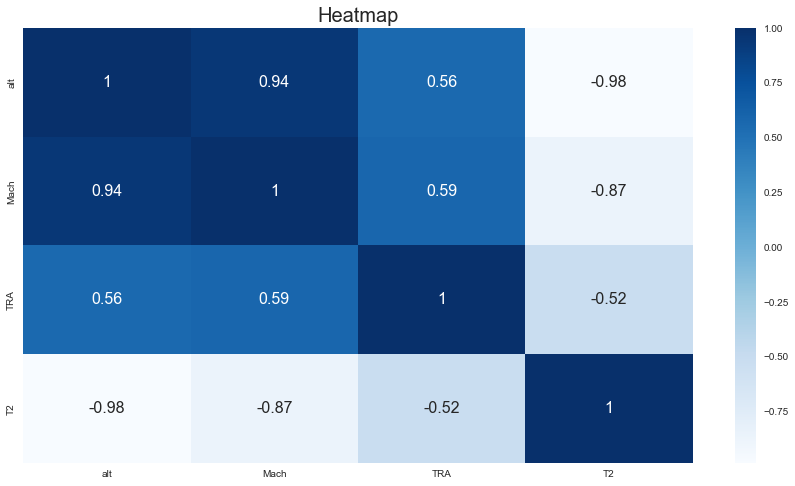

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df_W.drop(["unit"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)

plt.show()

In [7]:
df_X_s = DataFrame(data=X_s, columns=X_s_var) 
df_X_s['unit'] = df_W['unit'].values
df_X_s['alt'] = df_W['alt'].values
df_X_s['Mach'] = df_W['Mach'].values
df_X_s['TRA'] = df_W['TRA'].values
df_X_s['T2'] = df_W['T2'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,P50,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle
0,628.067440,1511.513103,1926.925730,1305.942703,20.030712,14.445617,20.335749,25.654299,433.588452,440.331422,16.506868,2240.817081,8822.782067,5.280657,1.0,3002.0,0.370377,81.122467,521.900827,1.0
1,628.055445,1511.458504,1926.939420,1305.955847,20.028054,14.444604,20.333050,25.650603,433.502638,440.242970,16.503124,2240.682999,8822.565341,5.279919,1.0,3010.0,0.370818,81.122467,521.904702,1.0
2,628.062671,1511.447754,1926.891685,1305.888172,20.027157,14.444141,20.332139,25.649811,433.463184,440.203438,16.499794,2240.711263,8822.534731,5.279245,1.0,3017.0,0.371259,81.122467,521.912580,1.0
3,628.074735,1511.440602,1926.851322,1305.806355,20.025641,14.443352,20.330600,25.648417,433.407051,440.146929,16.494665,2240.760181,8822.512894,5.278388,1.0,3030.0,0.372078,81.122467,521.926210,1.0
4,628.077782,1511.400057,1926.753906,1305.700646,20.023867,14.442366,20.328799,25.646643,433.331048,440.070597,16.489861,2240.761586,8822.386619,5.277163,1.0,3038.0,0.372519,81.122467,521.930527,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912647,565.680901,1276.304423,1501.160669,1140.995774,15.950512,13.629508,16.193413,18.248103,224.787221,229.534568,14.234020,1595.516489,8016.541455,2.157283,10.0,3031.0,0.234738,26.718559,513.457396,82.0
6912648,565.699290,1276.354738,1501.223033,1141.053145,15.953645,13.631977,16.196594,18.251652,224.838661,229.587043,14.237732,1595.545474,8016.708826,2.157831,10.0,3024.0,0.234486,26.718559,513.471020,82.0
6912649,565.719766,1276.404304,1501.294893,1141.118499,15.957024,13.634728,16.200025,18.255466,224.890152,229.639523,14.241438,1595.568394,8016.870106,2.158413,10.0,3017.0,0.234297,26.718559,513.487702,82.0
6912650,565.743753,1276.457027,1501.368062,1141.179715,15.960714,13.637842,16.203770,18.259656,224.943430,229.693862,14.244965,1595.596953,8017.041298,2.159010,10.0,3010.0,0.234234,26.718559,513.509052,82.0


In [8]:
df_X_s.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912652 entries, 0 to 6912651
Data columns (total 20 columns):
 #   Column  Dtype  
---  ------  -----  
 0   T24     float64
 1   T30     float64
 2   T48     float64
 3   T50     float64
 4   P15     float64
 5   P2      float64
 6   P21     float64
 7   P24     float64
 8   Ps30    float64
 9   P40     float64
 10  P50     float64
 11  Nf      float64
 12  Nc      float64
 13  Wf      float64
 14  unit    float64
 15  alt     float64
 16  Mach    float64
 17  TRA     float64
 18  T2      float64
 19  cycle   float64
dtypes: float64(20)
memory usage: 1.0 GB


In [9]:
df_X_s = df_X_s.astype(np.float16)
df_X_s['cycle'] = df_X_s['cycle'].astype(np.int8)
df_X_s['unit'] = df_X_s['unit'].astype(np.int8)
df_X_s.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6912652 entries, 0 to 6912651
Data columns (total 20 columns):
 #   Column  Dtype  
---  ------  -----  
 0   T24     float16
 1   T30     float16
 2   T48     float16
 3   T50     float16
 4   P15     float16
 5   P2      float16
 6   P21     float16
 7   P24     float16
 8   Ps30    float16
 9   P40     float16
 10  P50     float16
 11  Nf      float16
 12  Nc      float16
 13  Wf      float16
 14  unit    int8   
 15  alt     float16
 16  Mach    float16
 17  TRA     float16
 18  T2      float16
 19  cycle   int8   
dtypes: float16(18), int8(2)
memory usage: 250.5 MB


In [11]:
df_X_s

In [8]:
#selezione unita e ciclo
unit=1
cycle=10

<Figure size 432x288 with 0 Axes>

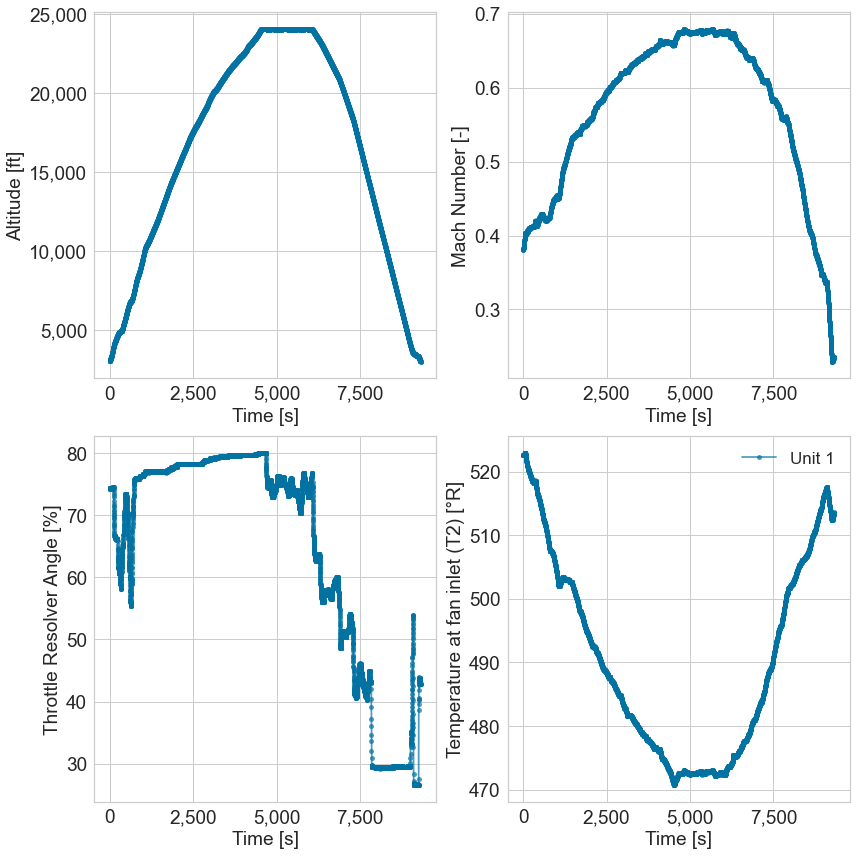

In [9]:
filter1 = df_X_s[df_X_s['unit']==unit]
filter1 = filter1[filter1['cycle']==cycle]
filter1.reset_index(inplace=True, drop=True)
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(filter1, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'.png')

In [10]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root
x = np.array(np.arange(len(df_X_s)))
y = np.array(df_X_s['alt'].to_list())

# calcolare la derivata
dy_dx = np.gradient(y, x)

# trovare i punti stazionari
stationary_points = x[np.where(dy_dx == 0)[0]]

print(stationary_points)

df_X_s = df_X_s.iloc[stationary_points]
df_X_s.reset_index(inplace=True)

[   3013    3014    3017 ... 6910785 6910788 6910809]


<Figure size 432x288 with 0 Axes>

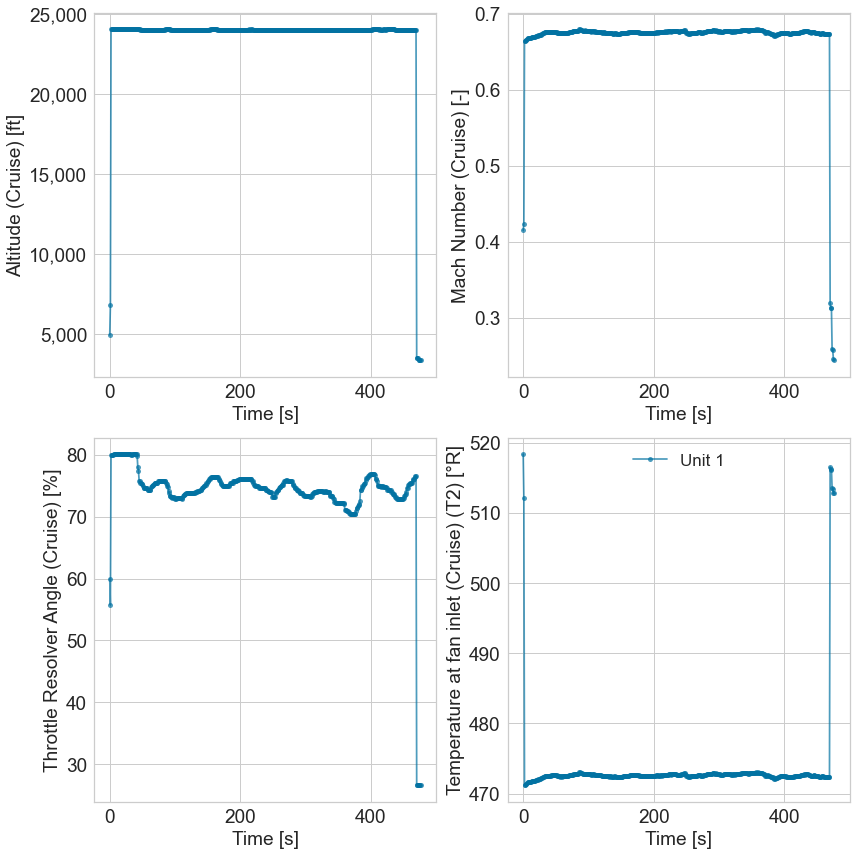

In [11]:
filter2 = df_X_s[df_X_s['unit']==unit]
filter2 = filter2[filter2['cycle']==cycle]
filter2.reset_index(inplace=True, drop=True)
labels = ['Altitude (Cruise) [ft]', 'Mach Number (Cruise) [-]', 'Throttle Resolver Angle (Cruise) [%]', 'Temperature at fan inlet (Cruise) (T2) [°R]']
plot_df_color_per_unit(filter2, W_var , labels, size=12, labelsize=19, name='./plot/flight_profile_'+ filename.replace('.h5','')+'_unit_'+str(unit)+'_cycle_'+str(cycle)+'_cruise_data.png')

## CLUSTERING

1.4298074965718954e-16 1.0000000000000004
(855549, 19)


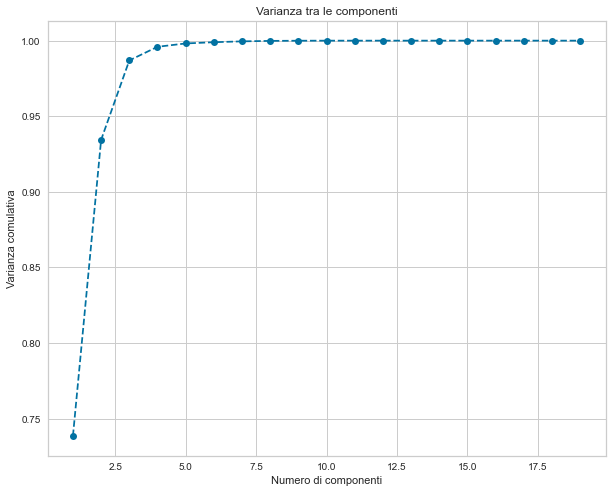

In [12]:
df_X_s_norm = KMeans.normalize_df(df_X_s.drop(columns=["unit",'cycle']))
KMeans.plot_variance_ratio(df_X_s_norm)

it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
Numero di cluster (k-means): 2


KMeans(n_clusters=2, random_state=42)

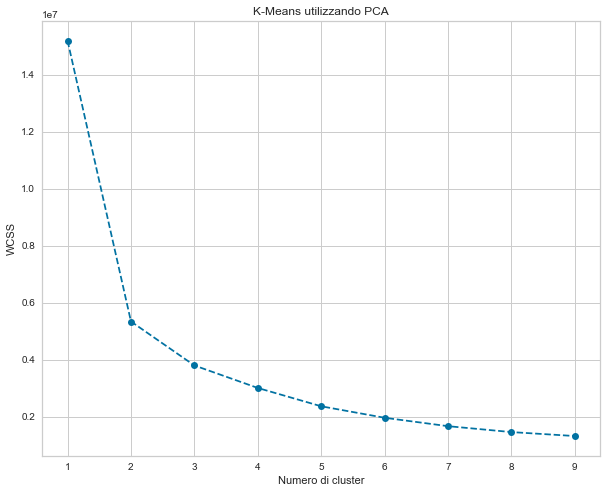

In [13]:
#prendiamo l'80% della varianza comulativa
scores_pca = KMeans.apply_pca(df_X_s_norm,2)
wcss = []
for i in range(1,10):
      kmeans_pca = KMeans.KMeans(n_clusters=i,init='k-means++',random_state=42)
      kmeans_pca.fit(scores_pca)
      wcss.append(kmeans_pca.inertia_)
      print("it",str(i))
plt.figure(figsize=(10,8))
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.title('K-Means utilizzando PCA')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
kl = KneeLocator(range(1,10),wcss,curve="convex",direction="decreasing")
print("Numero di cluster (k-means):",kl.elbow)
kmeans_pca = KMeans.KMeans(n_clusters=kl.elbow,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

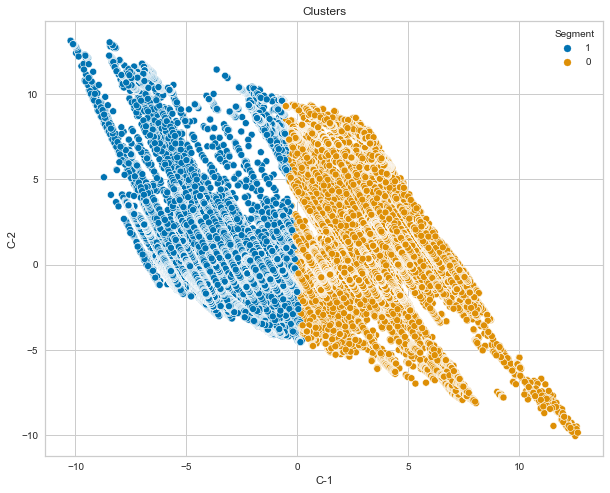

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,unit,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment
0,3013,567.884739,1359.484929,1706.980223,1126.593701,10.799996,7.907752,10.964463,13.878166,223.906276,...,1.0,22984.0,0.652869,79.452560,473.933456,1.0,-1.190520,-2.831975,1,1
1,3014,567.610471,1358.139522,1703.630302,1124.639009,10.788883,7.907769,10.953181,13.856620,223.122945,...,1.0,22984.0,0.652869,79.100998,473.933744,1.0,-1.240553,-2.732020,1,1
2,3017,566.662021,1353.915309,1695.958079,1120.912208,10.752993,7.912485,10.916744,13.782977,220.766269,...,1.0,22985.0,0.653625,77.958427,474.016431,1.0,-1.371599,-2.446966,1,1
3,3020,566.037902,1351.383753,1691.156704,1118.583037,10.729113,7.913807,10.892501,13.734710,219.352823,...,1.0,22987.0,0.653940,77.255310,474.042937,1.0,-1.452479,-2.272546,1,1
4,3021,565.780287,1350.621198,1690.457512,1118.463680,10.717276,7.910579,10.880484,13.714340,218.937448,...,1.0,22987.0,0.653436,77.079529,473.987688,1.0,-1.473976,-2.229131,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855544,6910778,576.083639,1357.971465,1674.813821,1159.043930,13.656922,10.694469,13.864896,16.847039,247.583985,...,10.0,13259.0,0.523215,57.655838,497.194557,82.0,2.166795,-0.538156,0,0
855545,6910783,575.879105,1357.149127,1673.026385,1158.125376,13.645517,10.691115,13.853317,16.827736,247.058584,...,10.0,13258.0,0.522711,57.480061,497.148073,82.0,2.135516,-0.480388,0,0
855546,6910785,575.782215,1357.020704,1673.160437,1158.338077,13.638555,10.685546,13.846249,16.818271,246.978088,...,10.0,13257.0,0.521892,57.480061,497.072222,82.0,2.131208,-0.476243,0,0
855547,6910788,575.677152,1356.888426,1673.141615,1158.421846,13.630892,10.678941,13.838469,16.808167,246.890751,...,10.0,13255.0,0.520884,57.480061,496.980640,82.0,2.125117,-0.470132,0,0


In [14]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)
KMeans.view_kmeans_results_2d(df_segm_pca_kmeans,scores_pca,kmeans_pca)

In [15]:
df_segm_pca_kmeans = KMeans.concat_df(df_X_s,scores_pca,kmeans_pca)

KMeans.calculate_centroids(df_segm_pca_kmeans,scores_pca,"",0)

-7.226639680443566e-17 0.9999999999999997
(435092, 21)
-1.9647218261056345e-15 1.0000000000000002
(420457, 21)


,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,Nf,Nc,Wf,unit,alt,Mach,TRA,T2,cycle,group
mean,3.632740e+06,580.370416,1352.018407,1650.838675,1153.390804,14.833587,11.714182,15.059480,18.094694,264.792004,...,1934.666968,8309.511731,2.807839,5.479531,10129.703522,0.462765,54.327129,503.889755,43.511071,0.0
mean,3.288956e+06,551.930620,1313.459606,1635.396527,1087.478820,9.638722,7.246857,9.785504,12.211042,189.673110,...,2036.202247,8186.256641,2.038569,4.996031,25429.145095,0.665751,72.220495,466.041534,37.563178,1.0


Text(0, 0.5, 'Flight Class # [-]')

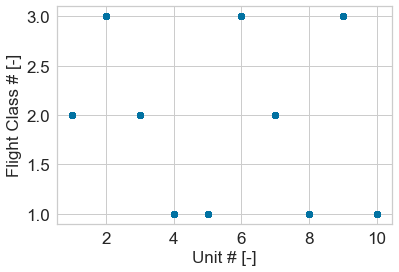

In [16]:
labelsize = 17
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit # [-]', fontsize=labelsize)
plt.ylabel('Flight Class # [-]', fontsize=labelsize )

In [17]:
dic = {}
for i in range(1,len(set(df_A.unit))+1):
    dic[i] = int(df_A[df_A.unit==i]["Fc"].iloc[0])
dic

{1: 2, 2: 3, 3: 2, 4: 1, 5: 1, 6: 3, 7: 2, 8: 1, 9: 3, 10: 1}

In [18]:
df_segm_pca_kmeans['class'] = df_segm_pca_kmeans['unit'].map(dic)
df_segm_pca_kmeans

,index,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,...,alt,Mach,TRA,T2,cycle,C-1,C-2,Segm K-means PCA,Segment,class
0,3013,567.884739,1359.484929,1706.980223,1126.593701,10.799996,7.907752,10.964463,13.878166,223.906276,...,22984.0,0.652869,79.452560,473.933456,1.0,-1.190520,-2.831975,1,1,2
1,3014,567.610471,1358.139522,1703.630302,1124.639009,10.788883,7.907769,10.953181,13.856620,223.122945,...,22984.0,0.652869,79.100998,473.933744,1.0,-1.240553,-2.732020,1,1,2
2,3017,566.662021,1353.915309,1695.958079,1120.912208,10.752993,7.912485,10.916744,13.782977,220.766269,...,22985.0,0.653625,77.958427,474.016431,1.0,-1.371599,-2.446966,1,1,2
3,3020,566.037902,1351.383753,1691.156704,1118.583037,10.729113,7.913807,10.892501,13.734710,219.352823,...,22987.0,0.653940,77.255310,474.042937,1.0,-1.452479,-2.272546,1,1,2
4,3021,565.780287,1350.621198,1690.457512,1118.463680,10.717276,7.910579,10.880484,13.714340,218.937448,...,22987.0,0.653436,77.079529,473.987688,1.0,-1.473976,-2.229131,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855544,6910778,576.083639,1357.971465,1674.813821,1159.043930,13.656922,10.694469,13.864896,16.847039,247.583985,...,13259.0,0.523215,57.655838,497.194557,82.0,2.166795,-0.538156,0,0,1
855545,6910783,575.879105,1357.149127,1673.026385,1158.125376,13.645517,10.691115,13.853317,16.827736,247.058584,...,13258.0,0.522711,57.480061,497.148073,82.0,2.135516,-0.480388,0,0,1
855546,6910785,575.782215,1357.020704,1673.160437,1158.338077,13.638555,10.685546,13.846249,16.818271,246.978088,...,13257.0,0.521892,57.480061,497.072222,82.0,2.131208,-0.476243,0,0,1
855547,6910788,575.677152,1356.888426,1673.141615,1158.421846,13.630892,10.678941,13.838469,16.808167,246.890751,...,13255.0,0.520884,57.480061,496.980640,82.0,2.125117,-0.470132,0,0,1


In [19]:
for i in range(0,3):
    filtered = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"]==i]
    contatori = filtered['class'].value_counts()
    df_contatori = pd.DataFrame({'Classe': contatori.index, 'Conteggio': contatori.values})
    print("cluster",i)
    print(df_contatori)
    print("totale cluster",i,":",df_contatori["Conteggio"].sum())


cluster 0
   Classe  Conteggio
0       1     198646
1       3     125339
2       2     111107
totale cluster 0 : 435092
cluster 1
   Classe  Conteggio
0       3     296102
1       2     122635
2       1       1720
totale cluster 1 : 420457
cluster 2
Empty DataFrame
Columns: [Classe, Conteggio]
Index: []
totale cluster 2 : 0


In [21]:
df_segm_pca_kmeans_f = df_segm_pca_kmeans[df_segm_pca_kmeans["Segm K-means PCA"] == 1]
df_W_u = df_segm_pca_kmeans_f[df_segm_pca_kmeans_f.unit == 8]
df_W_u.reset_index(inplace=True, drop=True)
df_W_u
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
#plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=19, name='flight_profile_DS02_clustering.png')
print('min:',df_W_u['alt'].min())
print('max:',df_W_u['alt'].max())

min: 8744.0
max: 17762.0
